<a href="https://colab.research.google.com/github/flaxoDS/CompletelyNew/blob/master/Mnist_Classifier_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

In [3]:
images = torch.randn(16, 3, 32, 32)
print("Shape", images.shape)

Shape torch.Size([16, 3, 32, 32])


In [4]:
bild = images[0]
bild_umgeformt = bild.permute(1, 2, 0)
print(bild_umgeformt.shape)

torch.Size([32, 32, 3])


In [5]:
images_reshaped= images.view(images.shape[0], -1)

In [6]:
im2 = images[1]
im1red = images[0][0]
im2greenmiddlerow = images[1][1][15]


In [7]:
import matplotlib.pyplot as plt


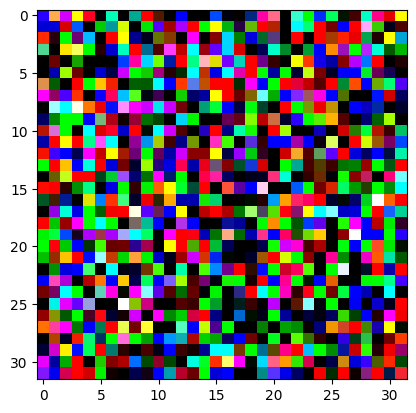

In [8]:
plt.imshow(bild_umgeformt)

In [9]:
from torchvision import datasets, transforms

In [10]:
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

bild, label = mnist_train[0]
print("Shape:", bild.shape)
print("Label:", label)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.43MB/s]

Shape: torch.Size([1, 28, 28])
Label: 5


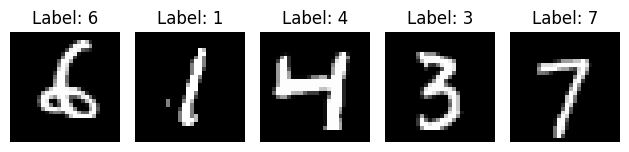

In [11]:
import random
anzahl = 5

for i in range(anzahl):
  index = random.randint(0, len(mnist_train) - 1)
  bild, label = mnist_train[index]

  plt.subplot(1, anzahl, i+1)
  plt.imshow(bild.squeeze(), cmap="gray")
  plt.title(f"Label: {label}")
  plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
bild, _ = mnist_train[0]
bild2d = bild.squeeze()
print("Nach squeeze:", bild2d.shape)

bild_original = bild2d.unsqueeze(0)
print("Nach unsqueeze:", bild_original.shape)




Nach squeeze: torch.Size([28, 28])
Nach unsqueeze: torch.Size([1, 28, 28])


In [13]:
a = torch.tensor([1, 2])
b = torch.tensor([3, 4])
c = torch.tensor([5, 6])

gestapelt = torch.stack([a, b, c])
print("Stacked:", gestapelt)
print("Shape:", gestapelt.shape)

Stacked: tensor([[1, 2],
        [3, 4],
        [5, 6]])
Shape: torch.Size([3, 2])


In [14]:
x = torch.randn(2, 3)

y = torch.randn(2, 3)

concat_zeilen = torch.cat([x, y], dim=0)
concat_spalten = torch.cat([x, y], dim = 1)

print("concat dim=0 (Zeilen):", concat_zeilen.shape)
print("Concat dim=1 (Spalten):", concat_spalten.shape)

concat dim=0 (Zeilen): torch.Size([4, 3])
Concat dim=1 (Spalten): torch.Size([2, 6])


In [15]:
x = torch.ones(3, 4)
row = torch.arange(4).float()

y = x + row

print("x Shape:", x.shape)
print("row Shape:", row.shape)
print("Ergebnis:\n", y)

x Shape: torch.Size([3, 4])
row Shape: torch.Size([4])
Ergebnis:
 tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]])


In [16]:
A = torch.randn(5, 2, 3)  # 5 Matrizen, jede 2×3
B = torch.randn(5, 3, 4)  # 5 Matrizen, jede 3×4

C = torch.bmm(A, B)       # Ergebnis: 5 Matrizen à 2×4
print(C.shape)            # → torch.Size([5, 2, 4])


torch.Size([5, 2, 4])


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [18]:
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader  = DataLoader(mnist_test, batch_size=1000)


In [19]:
class MNISTModell(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 Klassen

    def forward(self, x):
        x = x.view(x.shape[0], -1)     # [Batch, 1, 28, 28] → [Batch, 784]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)                # Kein Softmax → enthalten in Loss
        return x


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNISTModell().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [21]:
for epoch in range(5):  # 5 Durchläufe
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {running_loss / len(train_loader):.4f}")


Epoch 1: Loss = 0.3404
Epoch 2: Loss = 0.1412
Epoch 3: Loss = 0.0983
Epoch 4: Loss = 0.0733
Epoch 5: Loss = 0.0584


In [22]:
def evaluate(model, test_loader):
    model.eval()  # Switch to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # shape: [batch, 10]
            predictions = torch.argmax(outputs, dim=1)  # best class per sample

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.2%}")


In [23]:
evaluate(model, test_loader)


Test Accuracy: 97.43%
